# Analisi dati allenamento

## Data cleaning

Questo set di dati contiene informazioni su alcuni allenamenti giornalieri di un uomo, nel quale sono registrati le calorie consumate, il battito cardiaco, e la durata dell'allenamento.

Il nostro scopo sarà pulire i dati e poi effettuare delle semplici indagini statistiche per divertimento, esplorando la correlazione tra le variabili.

In [1]:
# Importo le librerie necessarie alla pulizia ed alla analisi statistica dei dati 
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [2]:
# Visualizzo le informazioni principali dei dati
df = pd.read_excel(r'E:\Lorenzo\datac.xlsx')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Duration  32 non-null     int64  
 1   Date      31 non-null     object 
 2   Pulse     32 non-null     int64  
 3   Maxpulse  32 non-null     int64  
 4   Calories  30 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.4+ KB


,Duration,Date,Pulse,Maxpulse,Calories
0,60,'2020/12/01',110,130,409.1
1,60,'2020/12/02',117,145,479.0
2,60,'2020/12/03',103,135,340.0
3,45,'2020/12/04',109,175,282.4
4,45,'2020/12/05',117,148,406.0


Noto che sono presenti dei valori nulli, nelle Calories e nelle Dates.

Le date sono inserite in modo sequenziale, quindi posso inserire al posto del dato mancanto il giorno successivo all'allenamento precedente.

In [3]:
# Cerco le date mancanti

date_mancanti = df['Date'].isnull()
df[date_mancanti]

,Duration,Date,Pulse,Maxpulse,Calories
22,45,NaN,100,119,282.0


In [4]:
# Ho una data mancante in 22-esima posizione
# Controllo quindi il giorno precedente per effettuare la corretta sostituzione

df['Date'][21]

"'2020/12/21'"

In [5]:
# Effettuo la sostituzione e successivamente converto la colonna in formato date per facilitare l'analisi

df.loc[22, 'Date'] = '2020/12/22'
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Sostituisco le calorie mancanti con la media della variabile

media_cal = df['Calories'].mean()
df['Calories'].fillna(media_cal, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Duration  32 non-null     int64         
 1   Date      32 non-null     datetime64[ns]
 2   Pulse     32 non-null     int64         
 3   Maxpulse  32 non-null     int64         
 4   Calories  32 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.4 KB


Non sono più presenti missing data.

Ora è necessario verificare se il dataset contiene outliers.

<AxesSubplot:xlabel='Date'>

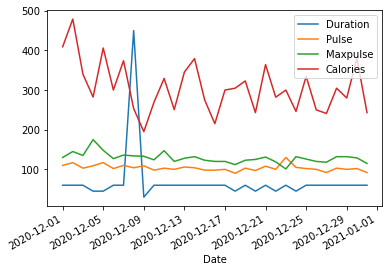

In [8]:
# Diamo una veloce occhiata al grafico dell'andamento delle variabili nel tempo

df.plot(x='Date')

Notiamo che è presente un inusuale picco per la durata dell'allenamento.

L'allenamento più lungo è durato 450 minuti!


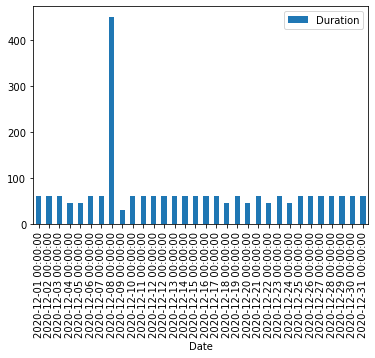

In [9]:
# Visualizziamo la serie della Duration

df.plot.bar(x='Date', y = "Duration")
print("L'allenamento più lungo è durato {} minuti!".format(df['Duration'].max()))


Molto probabilmente questo è un errore di digitazione e l'allenamento è durato 45 minuti.

Sostituiremo quindi questo valore con la nostra previsione.

<AxesSubplot:xlabel='Date'>

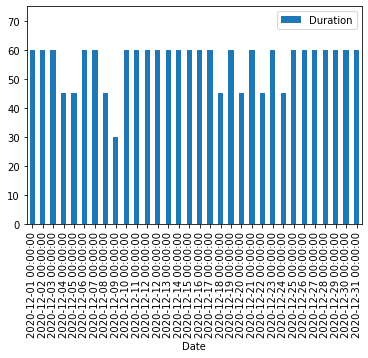

In [10]:
# Identifichiamo l'outlier con un loop ed iloc

for x in df.index:
    if df.loc[x, 'Duration'] == 450:
        df.loc[x, 'Duration'] = 45
df.plot.bar(x='Date', y = "Duration", ylim=(0,75))

## Analisi statistica

In [11]:
# Visulizzo la correlazione lineare tra variabili in una matrice

corr_lin= df.corr()
corr_lin.style.background_gradient().set_precision(3)


,Duration,Pulse,Maxpulse,Calories
Duration,1.000,-0.067,-0.259,0.323
Pulse,-0.067,1.000,0.277,0.487
Maxpulse,-0.259,0.277,1.000,0.347
Calories,0.323,0.487,0.347,1.000


Non sono presenti forti correlazioni lineari tra le calories e gli altri caratteri. 

Può essere utile visualizzare la concordanza.

In [12]:
# Visualizzo la concordanza con l'indice di Spearman

corr_spear = df.corr('spearman')
corr_spear.style.background_gradient().set_precision(3)

,Duration,Pulse,Maxpulse,Calories
Duration,1.000,-0.107,-0.209,0.272
Pulse,-0.107,1.000,0.659,0.575
Maxpulse,-0.209,0.659,1.000,0.451
Calories,0.272,0.575,0.451,1.000


Da questa tabella si può vedere che al crescere del battito cardiaco medio e massimo, c'è una moderata tendenza di crescita delle calorie consumate.

In [13]:
#   Con la regressione lineare, costruisco un modello che prevede le calorie in media data 
#   durata ed intensità (battito cardiaco medio e max) dell'allenamento

regr = smf.ols(formula = 'Calories ~ Pulse + Maxpulse + Duration', data = df)
mod = regr.fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     8.196
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           0.000452
Time:                        18:49:38   Log-Likelihood:                -167.82
No. Observations:                  32   AIC:                             343.6
Df Residuals:                      28   BIC:                             349.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -468.5577    156.690     -2.990      0.0

<AxesSubplot:xlabel='Maxpulse', ylabel='Calories'>

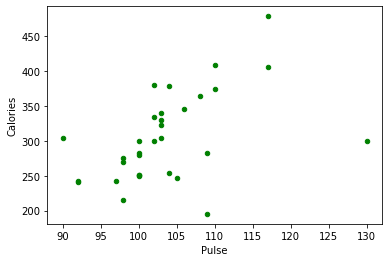

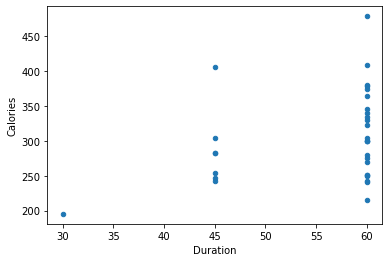

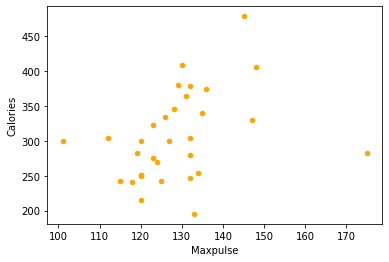

In [14]:
df.plot.scatter(x='Pulse', y='Calories', color = "Green")
df.plot.scatter(x='Duration', y='Calories')
df.plot.scatter(x='Maxpulse', y='Calories', color = "Orange")

Considerando i grafici a dispersione e l'indice r^2 molto basso possiamo concludere che il modello di regressione lineare non è efficace per modellizzare i nostri dati.
Come mai? Tra i principali motivi:

-Le calorie consumate dipendono da altri parametri non considerati, come il carico di allenamento, oppure semplicemente non seguono un modello lineare;

-La strumentazione usata non è accurata;


-I dati sono troppo pochi e la variabilità è troppo alta;

-Le calorie consumate includono anche quelle del metabolismo basale. Sottraendole alle calories probabilmente le differenze sarebbero più significative, e la relazione lineare spiegherebbe più variabilità.